 ## Import Google Earth API.
 This API contains all the functionalities of Google Earth Engine (GEE)

In [ ]:
import ee

## Initialize the authentication process.
This process will let you log in with your user name and password

In [ ]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

# Import Google Earth mapping capabilities

More information on the functionality of the *geemap* python package can be found at this [link](https://geemap.org/), which includes a [cheat sheet](https://geemap.org/cheatsheet/), [tutorials](https://geemap.org/tutorials/) and [book](https://book.geemap.org/) with valuable resources.
The syntax of many of the Google Earth Engine functions that are also callable with the *geemap* site package can be found under the [Client Libraries](https://developers.google.com/earth-engine/apidocs/).

In [ ]:
import pandas as pd
import numpy as np
import geemap
import geemap.colormaps as cm
Map =geemap.Map()
import json

## Data Access
Get access to [MODIS product of Ocean Color](https://developers.google.com/earth-engine/datasets/catalog/NASA_OCEANDATA_MODIS-Aqua_L3SMI#description)

In [ ]:
MODIS_OC_SST = ee.ImageCollection("NASA/OCEANDATA/MODIS-Aqua/L3SMI")

## Data Interrogation - Band names

In [ ]:
first_image = MODIS_OC_SST.first()
Bname = first_image.get('system:band_names')
print('system:band_names', Bname.getInfo())

system:band_names ['chlor_a', 'nflh', 'poc', 'Rrs_412', 'Rrs_443', 'Rrs_469', 'Rrs_488', 'Rrs_531', 'Rrs_547', 'Rrs_555', 'Rrs_645', 'Rrs_667', 'Rrs_678', 'sst']


## Data Filtering based on specific band, year

In [ ]:
selected_bands = 'sst'
sY=2003
sM=1
sD=1
eY=2021
eM=12
eD =31
start_date = ee.Date.fromYMD(sY, sM, sD)
end_date   = ee.Date.fromYMD(eY, eM, eD)

filtered_SST = MODIS_OC_SST.select(selected_bands).filter(ee.Filter.date(start_date, end_date))

## Counting number of images

In [ ]:
count = filtered_SST.size()
valCount=count.getInfo()
print('Numbre of images is : ', str(valCount))

Numbre of images is :  6849


# Decadal Mean of Daily SST Product

In [ ]:
DecadalMeanSST= filtered_SST.reduce(ee.Reducer.mean())

# Computing Monthly Mean

In [ ]:
#Create a series of years and months to loop on
years = ee.List.sequence(sY, eY)
months = ee.List.sequence(sM, eM)

#Define the functions getMonthlyMean and createMean

def getMonthlyMean(iy):
    def createMean(im):
        sDate = ee.Date.fromYMD(iy, im, sD)
        eDate = sDate.advance(1, 'month')
        monthFiltered = filtered_SST.filter(ee.Filter.date(sDate, eDate))
        msum = monthFiltered.reduce(ee.Reducer.mean())
        return msum.set({
            'system:time_start': sDate.millis(),
            'system:time_end': eDate.millis(),
            'year': iy,
            'month': im,
            'date': sDate.millis()})
    return months.map(createMean)

## Counting number of Monthly-Mean images

In [ ]:
monthly_SST = ee.ImageCollection.fromImages(years.map(getMonthlyMean).flatten())

count = monthly_SST.size()
valCount=count.getInfo()
print('Numbre of monthly mean images is : ', str(valCount)+'\n')

Numbre of monthly mean images is :  228



# Creating Geometry

In [ ]:
lat_range = (-5, 5)
lon_range = (-120, -170)
geometry = ee.Geometry.Rectangle(lon_range[0], lat_range[0], lon_range[1], lat_range[1])
#image = ee.ImageCollection('NASA/OCEANDATA/MODIS-Aqua/L3SMI').filterBounds(geometry).first()
#output_path = "./data.tif"  # Replace with the desired output file path
#geemap.ee_export_image(image, output_path, scale=1000, region=geometry)

# Time Series of Pacific (Monthly_Mean)

In [ ]:
def getTM4RoI(imgcol):
    def iter_func(image, newlist):
        date = ee.Number.parse(image.date().format("YYYYMMdd"))
        stat= image.reduceRegion(
            reducer = ee.Reducer.mean(),
            geometry = geometry,
            scale = 5000,
            maxPixels=1e15)

        newlist = ee.List(newlist)
        res = newlist.add([date, stat])
        return ee.List(res)
    ymd = imgcol.iterate(iter_func, ee.List([]))
    return list(ee.List(ymd).getInfo())

In [ ]:
inList = getTM4RoI(monthly_SST)

In [ ]:
def Convert2TM_DF(inList):
    newList =[]
    for i, item in enumerate(inList):
        if np.any(item[1].get('sst_mean')):
            newList.append([item[0],item[1].get('sst_mean')])
    DF=pd.DataFrame(newList,columns=['Dates' ,'SST'])
    datetime_series = pd.to_datetime(DF['Dates'],format='%Y%m%d')
    DF.drop('Dates', axis=1, inplace=True)
    DF.set_index(datetime_series, inplace=True,drop=True)
    DF.mask(DF.eq('None')).dropna()
    return DF

In [ ]:
TMonthly_Mean_SST  = Convert2TM_DF(inList)
TMonthly_Mean_SST .head()

,SST
Dates,
2003-01-01,27.491701
2003-02-01,27.292043
2003-03-01,27.647487
2003-04-01,27.664960
2003-05-01,27.414745


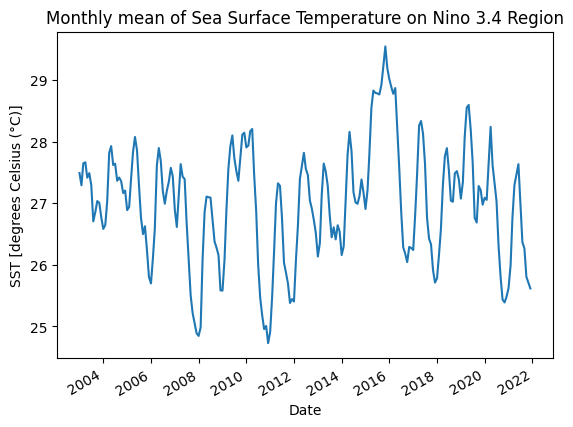

In [ ]:
import matplotlib.pyplot as plt
ax_=TMonthly_Mean_SST.plot(kind='line',
                    legend= False,
                    ylabel='SST [degrees Celsius (°C)]',
                    xlabel='Date',
                    title='Monthly mean of Sea Surface Temperature on Nino 3.4 Region')

plt.savefig('Monthly mean Timeseries.png')

## Compute the Monthly Climatology

In [ ]:
def getMonthlyClimatology(mm):
    img =  monthly_SST.filter(ee.Filter.calendarRange(sY,eY , 'year')).filter(ee.Filter.calendarRange(mm, mm, 'month'))
    msum = img.reduce(ee.Reducer.mean())
    timeStamp = ee.Date.fromYMD(sY,mm,1)
    return msum.set({
        'system:time_start': timeStamp.millis(),
        'system:time_end':   timeStamp.millis(),
        'year': sY,
        'month': mm,
        'date': timeStamp.millis()})

MonthlyClim= ee.ImageCollection.fromImages(months.map(getMonthlyClimatology).flatten())

In [ ]:
count = MonthlyClim.size()
valCount=count.getInfo()
print('Number of months count: ', str(valCount)+'\n')


Number of months count:  12



# Time Series of Pacific (Monthly_Climatology)

In [ ]:
def getTM4RoI(imgcol):
    def iter_func(image, newlist):
        date = ee.Number.parse(image.date().format("YYYYMMdd"))
        stat= image.reduceRegion(
            reducer = ee.Reducer.mean(),
            geometry = geometry,
            scale = 5000,
            maxPixels=1e15)
        newlist = ee.List(newlist)
        return ee.List(newlist.add([date, stat]))
    ymd = imgcol.iterate(iter_func, ee.List([]))
    return list(ee.List(ymd).getInfo())

In [ ]:
inList_2 = getTM4RoI(MonthlyClim)
inList_2

[[20030101, {'sst_mean_mean': 26.43159683325728}],
 [20030201, {'sst_mean_mean': 26.649322176272015}],
 [20030301, {'sst_mean_mean': 27.202452275519537}],
 [20030401, {'sst_mean_mean': 27.793321899811822}],
 [20030501, {'sst_mean_mean': 27.826695663894327}],
 [20030601, {'sst_mean_mean': 27.67784292409119}],
 [20030701, {'sst_mean_mean': 27.266555122939074}],
 [20030801, {'sst_mean_mean': 26.783904226487632}],
 [20030901, {'sst_mean_mean': 26.642087312728894}],
 [20031001, {'sst_mean_mean': 26.646256867915877}],
 [20031101, {'sst_mean_mean': 26.68326717383862}],
 [20031201, {'sst_mean_mean': 26.466276884433196}]]

In [ ]:
def Convert2TM_DF(inList_2):
    newList =[]
    for i, item in enumerate(inList_2):
        if np.any(item[1].get('sst_mean_mean')):
            newList.append([item[0],item[1].get('sst_mean_mean')])
    DF=pd.DataFrame(newList,columns=['Dates' ,'SST'])
    datetime_series = pd.to_datetime(DF['Dates'],format='%Y%m%d')
    DF.drop('Dates', axis=1, inplace=True)
    DF.set_index(datetime_series, inplace=True,drop=True)
    DF.mask(DF.eq('None')).dropna()
    return DF

In [ ]:
TMonthly_clim_SST  = Convert2TM_DF(inList_2)
TMonthly_clim_SST.head()


,SST
Dates,
2003-01-01,26.431597
2003-02-01,26.649322
2003-03-01,27.202452
2003-04-01,27.793322
2003-05-01,27.826696


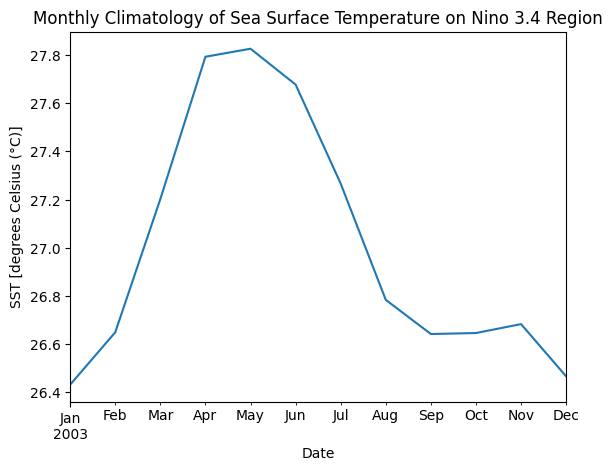

In [ ]:
ax_=TMonthly_clim_SST.plot(kind='line',
                    legend= False,
                    ylabel='SST [degrees Celsius (°C)]',
                    xlabel='Date',
                    title='Monthly Climatology of Sea Surface Temperature on Nino 3.4 Region')


plt.savefig('Monthly Climatology Timeseries.png')

## Monthly Climatology Standard Deviation

In [ ]:

def getMonthlyClimatology_std(mm):
    img =  monthly_SST.filter(ee.Filter.calendarRange(sY,eY , 'year')).filter(ee.Filter.calendarRange(mm, mm, 'month'))
    msum = img.reduce(ee.Reducer.stdDev())
    timeStamp = ee.Date.fromYMD(sY,mm,1)
    return msum.set({
        'system:time_start': timeStamp.millis(),
        'system:time_end':   timeStamp.millis(),
        'year': sY,
        'month': mm,
        'date': timeStamp.millis()})

## Number of Images

In [ ]:
MonthlyClim_std_dev= ee.ImageCollection.fromImages(months.map(getMonthlyClimatology).flatten())
count = MonthlyClim_std_dev.size()
valCount=count.getInfo()
print('Number of monthly Climatlogy images STD is : ', str(valCount)+'\n')

Number of monthly Climatlogy images STD is :  12



## Standardized Anomalies

In [ ]:
 MonthlyAnom =TMonthly_Mean_SST.groupby(TMonthly_Mean_SST.index.month).transform(lambda x: (x-x.mean())/x.std())

In [ ]:
MonthlyAnom

,SST
Dates,
2003-01-01,1.006456
2003-02-01,0.726718
2003-03-01,0.635098
2003-04-01,-0.238261
2003-05-01,-0.897969
...,...
2021-06-01,-0.096123
2021-08-01,-0.590432
2021-09-01,-0.455634


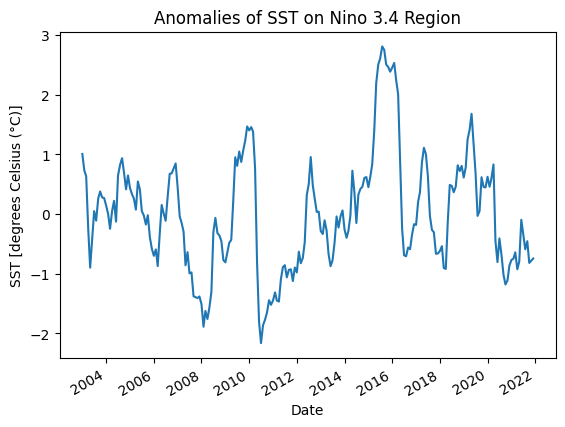

In [ ]:


ax_= MonthlyAnom.plot(kind='line',
                    legend= False,
                    ylabel='SST [degrees Celsius (°C)]',
                    xlabel='Date',
                    title='Anomalies of SST on Nino 3.4 Region')


plt.savefig('3_Anomaly.png')

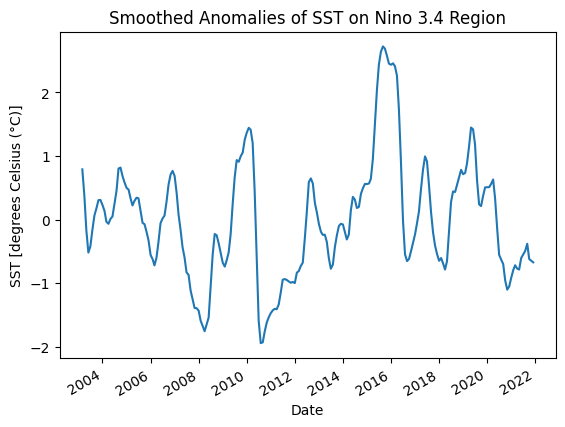

In [ ]:
Anom_smooth=MonthlyAnom.rolling(window=3).mean()


ax_= Anom_smooth.plot(kind='line',
                    legend= False,
                    ylabel='SST [degrees Celsius (°C)]',
                    xlabel='Date',
                    title='Smoothed Anomalies of SST on Nino 3.4 Region')


plt.savefig('3_Anomaly_Smooth.png')

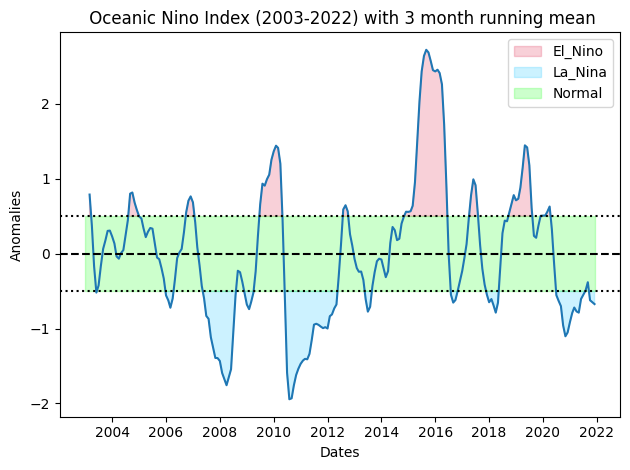

In [ ]:
import matplotlib.pyplot as plt
X=Anom_smooth.index
Y=Anom_smooth.SST
plt.plot(X, Y)
plt.xlabel("Dates")
plt.ylabel("Anomalies")
plt.title(" Oceanic Nino Index (2003-2022) with 3 month running mean")
plt.tight_layout()
El_Nino=0.5
La_Nina=-0.5
plt.axhline(y = 0, color = 'k', linestyle = '--')

plt.axhline(y = El_Nino, color = 'k', linestyle = ':')

plt.axhline(y = La_Nina, color = 'k', linestyle = ':')

plt.fill_between(X,Y, El_Nino,
                 where=(Y >= El_Nino),
                 alpha=0.20, color='crimson', interpolate=True,label= 'El_Nino')
plt.fill_between(X, Y, La_Nina,
                 where=(Y <= La_Nina),
                 alpha=0.20, color='deepskyblue', interpolate=True,label='La_Nina')

plt.fill_between(X, El_Nino, La_Nina, alpha=0.2, color='lime',label='Normal')

plt.legend()

plt.savefig('3 month_plot_new.png')

In [ ]:
Anom_smooth_5=MonthlyAnom.rolling(window=5).mean()

<AxesSubplot: xlabel='Dates'>

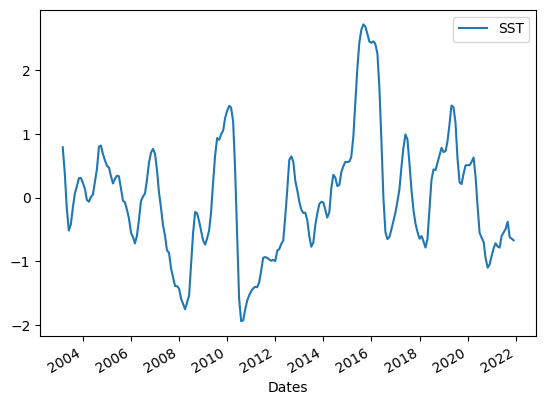

In [ ]:
Anom_smooth.plot()

In [ ]:
Anom_smooth.to_csv('Anom_smooth5.csv')

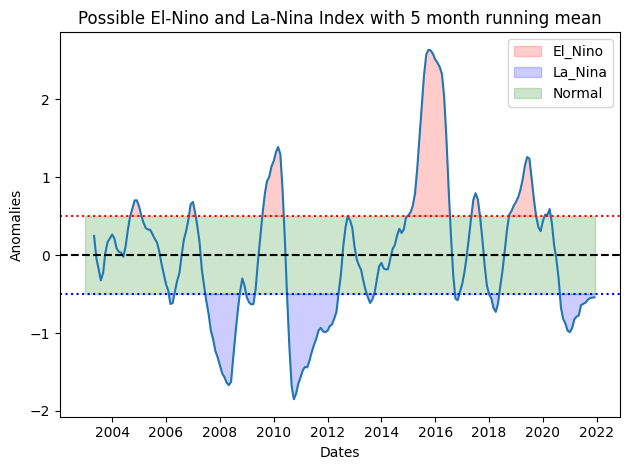

In [ ]:
import matplotlib.pyplot as plt
X=Anom_smooth_5.index
Y=Anom_smooth_5.SST
plt.plot(X, Y)
plt.xlabel("Dates")
plt.ylabel("Anomalies")
plt.title("Possible El-Nino and La-Nina Index with 5 month running mean")
plt.tight_layout()
El_Nino=0.5
La_Nina=-0.5
plt.axhline(y = 0, color = 'k', linestyle = '--')

plt.axhline(y = El_Nino, color = 'r', linestyle = ':')

plt.axhline(y = La_Nina, color = 'b', linestyle = ':')

plt.fill_between(X,Y, El_Nino,
                 where=(Y >= El_Nino),
                 alpha=0.20, color='red', interpolate=True,label= 'El_Nino')
plt.fill_between(X, Y, La_Nina,
                 where=(Y <= La_Nina),
                 alpha=0.20, color='blue', interpolate=True,label='La_Nina')

plt.fill_between(X, El_Nino, La_Nina, alpha=0.2, color='green',label='Normal')

plt.legend()

plt.savefig('5 month_plot.png')

# **Incorporating NOAA Timeseries from 1992**

In [ ]:
df = pd.read_csv('NOAA.csv')

In [ ]:
df

,Dates,SST
0,1992,1.7
1,1992,1.6
2,1992,1.5
3,1992,1.3
4,1992,1.1
...,...,...
367,2022,-0.9
368,2022,-1.0
369,2022,-1.0
370,2022,-0.9


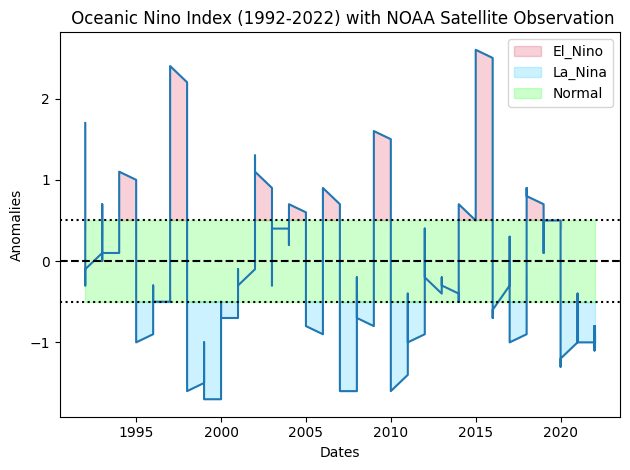

In [ ]:
import matplotlib.pyplot as plt
X=df.Dates
Y=df.SST
plt.plot(X, Y)
plt.xlabel("Dates")
plt.ylabel("Anomalies")
plt.title(" Oceanic Nino Index (1992-2022) with NOAA Satellite Observation")
plt.tight_layout()
El_Nino=0.5
La_Nina=-0.5
plt.axhline(y = 0, color = 'k', linestyle = '--')

plt.axhline(y = El_Nino, color = 'k', linestyle = ':')

plt.axhline(y = La_Nina, color = 'k', linestyle = ':')

plt.fill_between(X,Y, El_Nino,
                 where=(Y >= El_Nino),
                 alpha=0.20, color='crimson', interpolate=True,label= 'El_Nino')
plt.fill_between(X, Y, La_Nina,
                 where=(Y <= La_Nina),
                 alpha=0.20, color='deepskyblue', interpolate=True,label='La_Nina')

plt.fill_between(X, El_Nino, La_Nina, alpha=0.2, color='lime',label='Normal')

plt.legend()

plt.savefig('NOAA.png')